EDA for demographics_event_train
1. Merge dataset
2. Age 
3. Marital status

Questions:
- How different age related to motality/readmission
- How to deal with inbalanced dataset
- How to deal with event data (string of date-time) https://www.programiz.com/python-programming/datetime/strftime
- Check missing values and invalid values.
- How is agentorangeflag and serviceconnectedflag and veteran_flag relationships
- How ruca category related to motality/readmission
- Technique for imputating categorical data https://stackoverflow.com/questions/62015823/imputating-categorical-data-in-python-nearest-previous-value
- Encoding string/category to numbers.



Process columns: Age at update, Event date, Marital status, Ruca category
1. Clean nan/invalid values using imputation.
2. Encoding categorical values.



# Import Data & Basic Exploration

In [1]:
import pandas as pd


import numpy as np
import pandas as pd

import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import preprocess_data 

reload(preprocess_data)

%matplotlib inline

In [2]:
inpatients_with_readm = pd.read_csv('/home/daisy/FDA_Dataset/inpatients_with_readm.csv').iloc[:,1:]
inpatient_demographics_event = pd.read_csv('/home/bhatti/dataset/VCHAMPS/demographics_event_train.csv').iloc[:,1:]

In [363]:
inpatient_demographics_event = inpatients_with_readm.merge(demographics_event_train, how = 'left', on = 'Internalpatientid')
inpatient_demographics_event.head()

In [364]:
age_mortality = sns.FacetGrid(inpatient_demographics_event, col='Died during admission')
age_mortality.map(plt.hist, 'Age at admission', bins=20)

In [365]:
inpatient_demographics_event[inpatient_demographics_event['Died during admission'] == 'Yes']['Agentorangeflag'].value_counts() / inpatient_demographics_event['Agentorangeflag'].value_counts() 

In [366]:
inpatient_demographics_event[inpatient_demographics_event['Died during admission'] == 'Yes']['Serviceconnectedflag'].value_counts() / inpatient_demographics_event['Serviceconnectedflag'].value_counts() 

In [367]:
inpatient_demographics_event['Marital status'].value_counts()

Married                     73020
Divorced                    26856
Widowed                     19378
Never married                9352
Separated                    3708
Unknown                       534
Not specified (no value)      286
Single                        118
Name: Marital status, dtype: int64

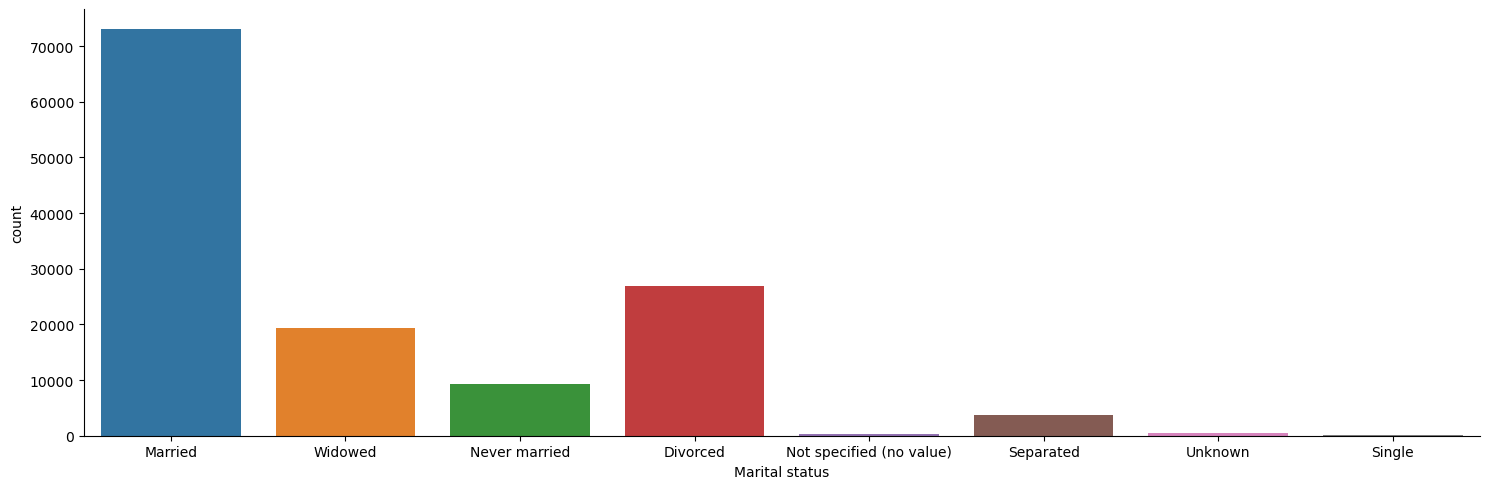

In [368]:
sns.catplot(data=inpatient_demographics_event, x='Marital status', kind="count", aspect=3)

In [369]:
inpatient_demographics_event['Ruca category'].value_counts()

Urban            84092
Rural            46614
Highly rural      2034
Not specified      512
Name: Ruca category, dtype: int64

In [370]:
# sns.catplot(data=inpatient_demographics_event, x='Ruca category', kind="count", aspect=1)

In [371]:
age_mortality = sns.FacetGrid(inpatient_demographics_event, col='Died during admission')
age_mortality.map(plt.hist, 'Ruca category', bins=20)

In [372]:
inpatient_demographics_event[inpatient_demographics_event['Died during admission'] == 'Yes']['Ruca category'].value_counts() / inpatient_demographics_event['Ruca category'].value_counts() 

## How different age related to motality

In [373]:
bins = list(range(0,100,10))
inpatient_demographics_event['agesgroup']=pd.cut(inpatient_demographics_event['Age at admission'],bins)


In [374]:
agesGroup = inpatient_demographics_event['agesgroup'].value_counts()

In [375]:
agesGroupDied = inpatient_demographics_event[inpatient_demographics_event['Died during admission'] == 'Yes']['agesgroup'].value_counts()

In [376]:
agesGroupDiedRate = agesGroupDied / agesGroup

We can see age is definitely related to death rate.

# Data Preprocessing


## Investigate Data
The columns for demographics_event: Age at update, Event date, Marital status, Ruca category.
- Age at update -> May have correlations with results.
- Event date -> May have correlations with results.
- Marital status -> Encoding to single / not single + imputating not specified.
- Ruca category -> Encoding to single / not single + imputating not specified.

(Also by checking the Nan values in the table, we can see Outpatientreferralflag, Serviceconnectedflag and Agentorangeflag have Nan may need to be preprocessed. 
E.g.
```inpatient_demographics_event['Serviceconnectedflag'] = inpatient_demographics_event['Serviceconnectedflag'].fillna('unknow')```,
```inpatient_demographics_event['Agentorangeflag'] = inpatient_demographics_event['Agentorangeflag'].fillna('unknow')```
)

In [3]:
pd.isnull(inpatient_demographics_event).sum()

Internalpatientid    0
Age at update        0
Event date           0
Marital status       0
Ruca category        0
dtype: int64

<Axes: ylabel='Age at update'>

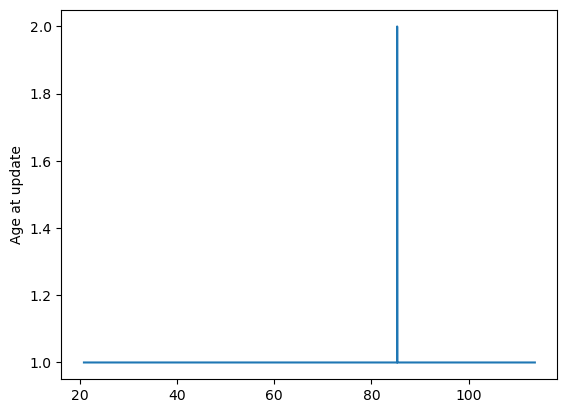

In [378]:
sns.lineplot(inpatient_demographics_event['Age at update'].value_counts())

In [379]:
inpatient_demographics_event['Event date'] = inpatient_demographics_event['Event date'].apply(preprocess_data.preprocess_time_string)

<Axes: ylabel='Event date'>

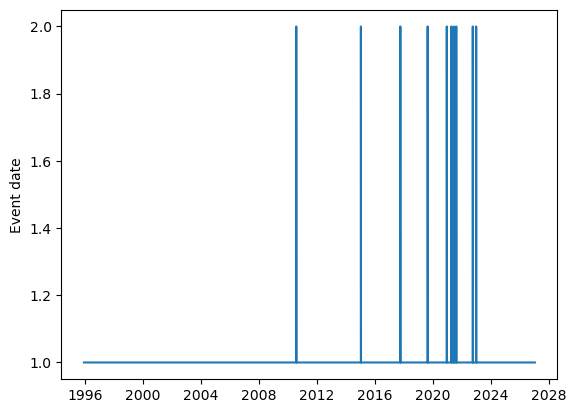

In [380]:
sns.lineplot(inpatient_demographics_event['Event date'].value_counts())

In [381]:
min(inpatient_demographics_event['Event date']) # There is no invalid data

Timestamp('1995-12-01 16:26:28')

In [382]:
inpatient_demographics_event['Marital status'].value_counts()

Married                     73020
Divorced                    26856
Widowed                     19378
Never married                9352
Separated                    3708
Unknown                       534
Not specified (no value)      286
Single                        118
Name: Marital status, dtype: int64

In [383]:
inpatient_demographics_event['Ruca category'].value_counts()

Urban            84092
Rural            46614
Highly rural      2034
Not specified      512
Name: Ruca category, dtype: int64

## Encoding categorical data
For Marital status:
- Divorced -> Not single - 0
- Never married, Separated, Single， Widowed -> Single - 1
- Not specified (no value) -> imputate

For Ruca category:
- Urban -> Urban - 1
- Highly rural, Rural -> Not urban - 0
- Not specified -> Imputate

In [384]:
marital_status = {'Married': 1, 'Divorced': 0, 'Never married': 1, 'Separated': 1, 'Single': 1, 'Unknown': None, 'Widowed': 1, 'Not specified (no value)': None}
ruca_category = {'Urban': 1, 'Highly rural': 0, 'Rural': 0, 'Not specified': None}

In [385]:
inpatient_demographics_event['Marital status encoded'] = preprocess_data.preprocess_substitute_categories(marital_status, 
                                                                               inpatient_demographics_event['Marital status'])

In [386]:
inpatient_demographics_event['Ruca category encoded'] = preprocess_data.preprocess_substitute_categories(ruca_category, 
                                                                               inpatient_demographics_event['Ruca category'])

In [387]:
inpatient_demographics_event['Ruca category encoded'].value_counts()

1.0    84092
0.0    48648
Name: Ruca category encoded, dtype: int64

In [388]:
inpatient_demographics_event['Ruca category encoded']

0         1.0
1         0.0
2         1.0
3         1.0
4         1.0
         ... 
133247    1.0
133248    0.0
133249    1.0
133250    1.0
133251    1.0
Name: Ruca category encoded, Length: 133252, dtype: float64

In [389]:
inpatient_demographics_event['Marital status encoded'] = preprocess_data.imputate_nan_binary(inpatient_demographics_event['Marital status encoded'])

/home/vivi/FDA/src/data/preprocess_data.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [390]:
inpatient_demographics_event['Ruca category encoded'] = preprocess_data.imputate_nan_binary(inpatient_demographics_event['Ruca category encoded'])

/home/vivi/FDA/src/data/preprocess_data.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [332]:
pd.isnull(inpatient_demographics_event).sum()

Internalpatientid                                           0
Age at admission                                            0
Admission date                                              0
Discharge date                                            494
Admitting unit service                                      0
Discharging unit service                                    0
Admitting specialty                                         0
Discharging specialty                                       0
First listed discharge diagnosis icd10 subcategory          0
Second listed discharge diagnosis icd10 subcategory         0
Discharge disposition                                       0
Died during admission                                       0
Outpatientreferralflag                                  26443
Serviceconnectedflag                                   487689
Agentorangeflag                                        104512
State                                                       0
Hospital

In [4]:
inpatient_demographics_event

,Internalpatientid,Age at update,Event date,Marital status,Ruca category
0,100028,78.990830,2020-08-24 03:33:32.0,Married,Urban
1,100032,91.357622,2008-02-07 05:03:27.0,Married,Rural
2,100046,72.961415,2003-09-14 09:32:12.0,Married,Urban
3,100071,75.221222,2019-04-25 08:33:42.0,Widowed,Urban
4,100091,80.955929,2022-02-09 09:24:20.0,Never married,Urban
...,...,...,...,...,...
133247,99898,92.376313,2014-05-12 13:01:07.0,Married,Urban
133248,9995,79.974938,2011-07-08 20:09:29.0,Married,Rural
133249,99950,77.154395,2005-12-14 22:21:25.0,Married,Urban
133250,9998,62.324623,2011-02-23 15:35:32.0,Divorced,Urban
